In [ ]:
from openpyxl import load_workbook
from openpyxl.styles import Alignment

import os
QRM_path = os.path.dirname(os.getcwd()) 
file_path = QRM_path+'//Homework//Calibration.xlsm'

wb = load_workbook(filename=file_path, data_only=True)

ws = wb['Discount Curve']  # or wb.active

# os.system('start "excel" ' + '"' + file_path + '"')


0

In [161]:
import numpy as np
from scipy.interpolate import splrep, BSpline
import matplotlib.pyplot as plt

# Get all matrices
Matrices = dict()
for dn in list(wb.defined_names):
    data_range = wb.defined_names[dn]
    matrix = []
    for sheetname, cellAddress in data_range.destinations:
        cellAddress = cellAddress.replace('$','')
        try:
            nrows = len(ws[cellAddress][0][0:-1])+1
            ncols = len(ws[cellAddress])
            for i in range(nrows):
                matrix.append([])
                for j in range(ncols):
                    matrix[i].append(ws[cellAddress][j][i].value)
            Matrices[dn] = np.array(matrix).transpose()
        except:
            Matrices[dn] = np.array([ws[cellAddress].value])



[ 0.08055556  0.08055556  0.08055556  0.08055556  0.33055556  0.58055556
  1.08055556  3.5        10.         10.         10.         10.        ]


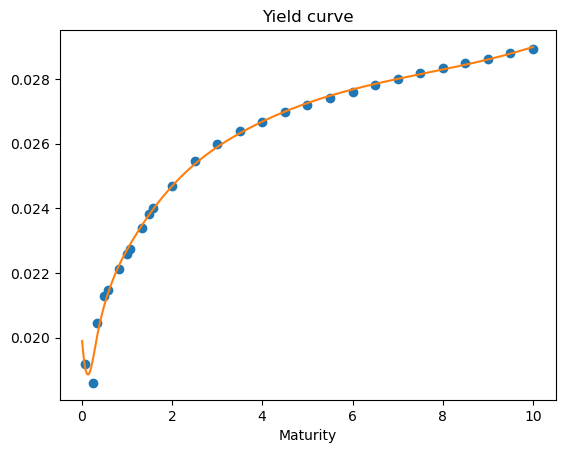

In [160]:
## Discount Curve via Moore Penrose Pseudoinverse matrix method
# D. Filipovic, W. Sanders, Exact Smooth Term Structure (2016)

# Discount Rates via Pseuroinverse matrix method
C = Matrices["CashFlows"]
p = Matrices["Prices"]
T = Matrices["Dates"].T

[n,N] = np.shape(C); 

I = np.eye(N)
M = I-np.eye(N=N,k=-1)
Minv = np.linalg.inv(M)
T0 = np.vstack((0,T[:-1]))
dT = 1/np.sqrt( T - T0 )
W = np.diag(dT.ravel())
Winv = np.linalg.inv(W)
A = C  @ ( Minv ) @ ( Winv )
D = A.T @ ( np.linalg.inv(A @ A.T) ) @ ( p - C @ ( Minv ) @ np.eye(N=N,M=1) )
d = ( Minv ) @ ( Winv @ D + np.eye(N=N,M=1) )

# Interpolation via smoothing splines and plot
yy = -np.log(d) / T; # compute yields
y = splrep(T, yy, s=0.000001)
print(y[0])
# Create the plot
plt.plot(T, yy, 'o')
Tnew = np.linspace(0.01,10,1000)
plt.plot(Tnew, BSpline(*y)(Tnew))
plt.xlabel('Maturity')
plt.title('Yield curve')
plt.show()

# Discount Curve
d = np.exp(-yy*T); # discount curve